**This is the code for taining the model that recognises facial emotion from the picture.
This is the 5th version which resulted in highest accuracy among other code**

In [ ]:
#importing necessary libraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import cv2
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

import zipfile


In [ ]:
##unzip files

def unzip_file(zip_path, extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Unzipped {zip_path} to {extract_to}")


unzip_file("dataset/FER2013.zip", "dataset/")


Unzipped dataset/FER2013.zip to dataset/


In [ ]:
#directory
trainDataDir = "dataset/train/"
testDataDir = "dataset/test/"

classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"] #all the classes from the dataset



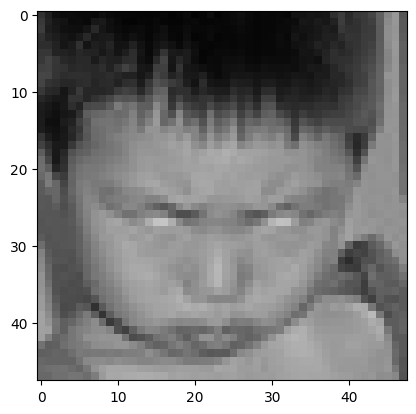

In [ ]:
#displaying image
img_array = cv2.imread("dataset/train/angry/Training_10118481.jpg")

plt.imshow(img_array)

In [ ]:
# creating ImageDataGenerator for training
# we are augmenting the data to make model learn properly.
# We are trying to avoid model from learning specific pattern so changing the image makes the model a little more accurate.
trainDataGen = ImageDataGenerator(
    rescale=1.0/255.0,         # we are normalising pixel value to similar range, helps with training
    rotation_range=10,         # ratotaing the data by little bit. since rotating too much might remove facial expression and image is really small.
    width_shift_range=0.05,    # same as before
    height_shift_range=0.05,   # same as before
    zoom_range=0.1,            # zomming by little bit since image is small and don't want to remove necassary data
    horizontal_flip=True,      # flipping the image
    fill_mode="nearest"        # filling the gap that exists after transforming
)

# creating ImageDataGenerator for testing
# we are only rescaling test data since I want to avoid using too much resource
testDataGen = ImageDataGenerator(
    rescale=1.0/255.0
)


In [ ]:
trainGenerator = trainDataGen.flow_from_directory(
    trainDataDir,
    target_size=(224, 224),  # Resize images to match the input size of model
    batch_size=64,           # Number of samples per batch
    class_mode='sparse', # providing the labels as int
    shuffle=True  # shuffling the image to prevent it from learning the pattern
)

testGenerator = testDataGen.flow_from_directory(
    testDataDir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
#loading the model
model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
#model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#removing the premade layer and adding our own
from tensorflow.keras.layers import Dropout
baseInput = model.input
baseOutput = model.layers[-1].output

# Custom fully connected layers

finalOutput = layers.GlobalAveragePooling2D()(baseOutput)
finalOutput = layers.Dense(128)(finalOutput)
finalOutput = layers.Activation("relu")(finalOutput)
finalOutput = Dropout(0.5)(finalOutput)
finalOutput = layers.Dense(64)(finalOutput)
finalOutput = layers.Activation("relu")(finalOutput)
finalOutput = Dropout(0.5)(finalOutput)
finalOutput = layers.Dense(7, activation="softmax")(finalOutput)

In [ ]:
#creating new model
newModel = keras.Model(inputs = baseInput, outputs = finalOutput)

In [ ]:
#compiling the model
newModel.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
#making a function to decrease learning rate when the model has stopped improving

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [ ]:
#training the model
newModel.fit(
    trainGenerator,
    epochs=20,
    validation_data=testGenerator,
    callbacks=[lr_scheduler]
)

Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 384s 841ms/step - accuracy: 0.6800 - loss: 0.8958 - val_accuracy: 0.5577 - val_loss: 1.5157 - learning_rate: 5.0000e-04
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 427s 809ms/step - accuracy: 0.6917 - loss: 0.8646 - val_accuracy: 0.6291 - val_loss: 1.0111 - learning_rate: 5.0000e-04
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 381s 808ms/step - accuracy: 0.6959 - loss: 0.8589 - val_accuracy: 0.6343 - val_loss: 1.0103 - learning_rate: 5.0000e-04
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 381s 809ms/step - accuracy: 0.7056 - loss: 0.8330 - val_accuracy: 0.6010 - val_loss: 1.2156 - learning_rate: 5.0000e-04
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 377s 830ms/step - accuracy: 0.7215 - loss: 0.8016 - val_accuracy: 0.6369 - val_loss: 1.0113 - learning_rate: 5.0000e-04
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.7221 - loss: 0.7898
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
449/449 ━━━━━━━━━━━━━━━━━━━━ 371s 81

In [ ]:
#saving the model to use on other project
newModel.save('EmotionEcho_v5.keras')